### Машинное Обучения

## Домашнее задание по лекции - Деревья решений

**Общая информация**

**Срок сдачи:** 2 декабря 2024, 23:59   
**Штраф за опоздание:** -2 балла за каждые 2 дня опоздания

Решение залить в свой github репозиторий.

Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс MyDecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict . (Но название класса не менять)

In [338]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [342]:
class MyDecisionTreeClassifier:
    def __init__(self, min_samples_split=2, min_impurity=1e-7, max_depth=float("inf"), criterion='entropy'):
        self.min_samples_split = min_samples_split
        self.min_impurity = min_impurity
        self.max_depth = max_depth
        self.criterion = criterion
        self.tree = None
        self.feature_importances_ = None  # Суммарный gain для признаков

    def _calculate_entropy(self, y):
        counts = np.bincount(y)
        probabilities = counts / len(y)
        return -np.sum(probabilities * np.log2(probabilities + 1e-9))  # Добавляем шум для избежания log(0)

    def _calculate_gini(self, y):
        counts = np.bincount(y)
        probabilities = counts / len(y)
        return 1 - np.sum(probabilities ** 2)

    def _calculate_misclassification_error(self, y):
        """Ошибка классификации"""
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        return 1 - np.max(probabilities)

    def _calculate_impurity(self, y, y1, y2):
        if self.criterion == 'entropy':
            impurity_func = self._calculate_entropy
        elif self.criterion == 'gini':
            impurity_func = self._calculate_gini
        elif self.criterion == 'misclassification':
            impurity_func = self._calculate_misclassification_error
        else:
            raise ValueError("Критерий должен быть 'entropy' или 'gini' или 'misclassification'")

        p = len(y1) / len(y)
        return impurity_func(y) - p * impurity_func(y1) - (1 - p) * impurity_func(y2)

    def _best_split(self, X, y):
        n_samples, n_features = X.shape
        best_gain = -np.inf
        best_criteria = None

        for feature_i in range(n_features):
            thresholds = np.percentile(X[:, feature_i], np.linspace(0, 100, 10))
            for threshold in thresholds:
                left_idx = X[:, feature_i] < threshold
                right_idx = ~left_idx

                if left_idx.sum() < self.min_samples_split or right_idx.sum() < self.min_samples_split:
                    continue

                gain = self._calculate_impurity(y, y[left_idx], y[right_idx])
                if gain > best_gain:
                    best_gain = gain
                    best_criteria = {"feature_i": feature_i, "threshold": threshold, "left_idx": left_idx, "right_idx": right_idx}

        return best_criteria if best_gain > self.min_impurity else None

    def _build_tree(self, X, y, depth=0):
        n_samples = len(y)
        if self.feature_importances_ is None:
            self.feature_importances_ = np.zeros(X.shape[1])

        if n_samples >= self.min_samples_split and depth < self.max_depth:
            best_split = self._best_split(X, y)
            if best_split:
                left_idx, right_idx = best_split["left_idx"], best_split["right_idx"]

                feature_idx = best_split["feature_i"]
                gain = self._calculate_impurity(y, y[left_idx], y[right_idx])
                self.feature_importances_[feature_idx] += gain

                true_branch = self._build_tree(X[left_idx], y[left_idx], depth + 1)
                false_branch = self._build_tree(X[right_idx], y[right_idx], depth + 1)

                return {"feature_i": feature_idx, "threshold": best_split["threshold"],
                        "true_branch": true_branch, "false_branch": false_branch}

        leaf_value = np.bincount(y).argmax()
        return {"value": leaf_value}

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        self.n_features_ = X.shape[1]
        self.feature_importances_ = np.zeros(self.n_features_)
        self.tree = self._build_tree(X, y)

    def _predict_sample(self, sample, tree):
        while "value" not in tree:
            feature_i = tree["feature_i"]
            threshold = tree["threshold"]
            tree = tree["true_branch"] if sample[feature_i] < threshold else tree["false_branch"]
        return tree["value"]

    def predict(self, X):
        return np.array([self._predict_sample(sample, self.tree) for sample in X])

    def get_feature_importance(self):
        """Возвращает важность признаков на основе суммарного gain."""
        importance = self.feature_importances_
        importance /= np.sum(importance)
        return importance


In [343]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [344]:
clf = DecisionTreeClassifier(min_samples_split=2)
clf.fit(X_train, y_train)


my_clf = MyDecisionTreeClassifier(min_samples_split=2)
my_clf.fit(X_train, y_train)


y_pred_sklearn = clf.predict(X_test)
y_pred_custom = my_clf.predict(X_test)


print("Sklearn Tree Accuracy:", accuracy_score(y_test, y_pred_sklearn))
print("Custom Tree Accuracy:", accuracy_score(y_test, y_pred_custom))

Sklearn Tree Accuracy: 0.7777777777777778
Custom Tree Accuracy: 0.8333333333333334


Совет: Проверьте, что ваша реализация корректно работает с признаками в которых встречаются повторы.
И подумайте, какие еще граничные случаи могут быть.
Например, проверьте, что на таком примере ваша модель корректно работает:

In [345]:
X = np.array([[1] * 10, [0, 1, 2, 5, 6, 3, 4, 7, 8, 9]]).T
y = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])
for depth in range(1, 5):
    my_clf = MyDecisionTreeClassifier(max_depth=depth)
    my_clf.fit(X, y)
    print("DEPTH:", depth, "\n\t\tTree:", my_clf.tree, my_clf.predict(X))

DEPTH: 1 
		Tree: {'feature_i': 1, 'threshold': 2.999999999999999, 'true_branch': {'value': 0}, 'false_branch': {'value': 1}} [0 0 0 1 1 1 1 1 1 1]
DEPTH: 2 
		Tree: {'feature_i': 1, 'threshold': 2.999999999999999, 'true_branch': {'value': 0}, 'false_branch': {'feature_i': 1, 'threshold': 6.333333333333334, 'true_branch': {'value': 0}, 'false_branch': {'value': 1}}} [0 0 0 0 0 0 0 1 1 1]
DEPTH: 3 
		Tree: {'feature_i': 1, 'threshold': 2.999999999999999, 'true_branch': {'value': 0}, 'false_branch': {'feature_i': 1, 'threshold': 6.333333333333334, 'true_branch': {'feature_i': 1, 'threshold': 4.333333333333333, 'true_branch': {'value': 1}, 'false_branch': {'value': 0}}, 'false_branch': {'value': 1}}} [0 0 0 0 0 1 1 1 1 1]
DEPTH: 4 
		Tree: {'feature_i': 1, 'threshold': 2.999999999999999, 'true_branch': {'value': 0}, 'false_branch': {'feature_i': 1, 'threshold': 6.333333333333334, 'true_branch': {'feature_i': 1, 'threshold': 4.333333333333333, 'true_branch': {'value': 1}, 'false_branch': {

## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine.
Для этого используем numpy.

Первая попытка ускорить

In [106]:
%time clf.fit(X_train, y_train)

CPU times: user 4.62 ms, sys: 0 ns, total: 4.62 ms
Wall time: 7.75 ms


DecisionTreeClassifier()

In [107]:
%time my_clf.fit(X_train, y_train)

CPU times: user 880 ms, sys: 12.4 ms, total: 892 ms
Wall time: 895 ms


Вторая попытка ускорить

In [111]:
%time clf.fit(X_train, y_train)

CPU times: user 3.51 ms, sys: 20 µs, total: 3.53 ms
Wall time: 4.45 ms


DecisionTreeClassifier()

In [112]:
%time my_clf.fit(X_train, y_train)

CPU times: user 320 ms, sys: 2.02 ms, total: 322 ms
Wall time: 324 ms


Тертья попытка ускорить

In [120]:
%time clf.fit(X_train, y_train)

CPU times: user 4.7 ms, sys: 0 ns, total: 4.7 ms
Wall time: 12.3 ms


DecisionTreeClassifier()

In [154]:
%time my_clf.fit(X_train, y_train)

CPU times: user 97 ms, sys: 0 ns, total: 97 ms
Wall time: 97.6 ms


## Боевое применение (3 балла)

Работаем с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match).

Данные и описания колонок во вложениях.

Либо можно воспользоваться функцией:

In [347]:
def preprocess_spd_data(df):
    to_drop = [
        'id', 'idg', 'condtn', 'round', 'position', 'positin1', 'order', 'partner',
        'age_o', 'race_o', 'pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
        'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o', 'shar_o', 'like_o', 'prob_o', 'met_o',
        'field', 'undergra', 'from', 'zipcode', 'income', 'career',
        'mn_sat', 'tuition'
    ]

    df = df.drop(to_drop, axis=1)

    df['field_cd'] = df['field_cd'].fillna(df['field_cd'].mode()[0])
    df['career_c'] = df['career_c'].fillna(df['career_c'].mode()[0])

    df.fillna(df.median(numeric_only=True), inplace=True)

    attr_cols = ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']
    df[attr_cols] = df[attr_cols].div(df[attr_cols].sum(axis=1), axis=0) * 100

    num_cols = ['age', 'imprelig', 'imprace', 'date', 'go_out']
    scaler = StandardScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])

    cat_cols = ['gender', 'goal']
    label_encoder = LabelEncoder()
    for col in cat_cols:
        if col in df.columns:
            df[col] = label_encoder.fit_transform(df[col])

    df = pd.get_dummies(df, columns=['race', 'date_3', 'go_out'], drop_first=True)

    df.dropna(inplace=True)

    return df


Скачайте датасет, обработайте данные, обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. В качестве метрики можно взять roc-auc.


In [209]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [346]:
dataset = pd.read_csv('/content/drive/MyDrive/ML_ВШЭ/Speed_Dating_Data.csv', encoding = 'Windows-1252')

In [348]:
dataset.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


In [349]:
dataset = preprocess_spd_data(dataset)

In [350]:
dataset.head()

,iid,gender,wave,pid,match,int_corr,samerace,age,field_cd,imprace,...,race_3.0,race_4.0,race_6.0,date_3_1.0,go_out_-0.14235605618697297,go_out_0.7666828452874633,go_out_1.6757217467618997,go_out_2.584760648236336,go_out_3.4937995497107726,go_out_4.402838451185208
0,1,0,1,11.0,0,0.14,0,-1.509911,1.0,-0.627366,...,False,True,False,False,False,False,False,False,False,False
1,1,0,1,12.0,0,0.54,0,-1.509911,1.0,-0.627366,...,False,True,False,False,False,False,False,False,False,False
2,1,0,1,13.0,1,0.16,1,-1.509911,1.0,-0.627366,...,False,True,False,False,False,False,False,False,False,False
3,1,0,1,14.0,1,0.61,0,-1.509911,1.0,-0.627366,...,False,True,False,False,False,False,False,False,False,False
4,1,0,1,15.0,1,0.21,0,-1.509911,1.0,-0.627366,...,False,True,False,False,False,False,False,False,False,False


In [351]:
X = dataset.drop('match', axis=1)
y = dataset['match']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [323]:
my_clf = MyDecisionTreeClassifier(min_samples_split=5, max_depth=3, criterion='entropy')
my_clf.fit(X_train.values, y_train.values)


y_pred_proba = my_clf.predict(X_test.values)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"ROC-AUC на тестовой выборке: {roc_auc:.3f}")

ROC-AUC на тестовой выборке: 0.668


Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности.
Постройте графики зависимости точности на валидации и трейне от глубины дерева, от минимального числа объектов для сплита. (Т.е должно быть 2 графика, на каждой должны быть 2 кривые - для трейна и валидации)
Какой максимальной точности удалось достигнуть?

In [333]:
X = dataset.drop('match', axis=1)
y = dataset['match']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

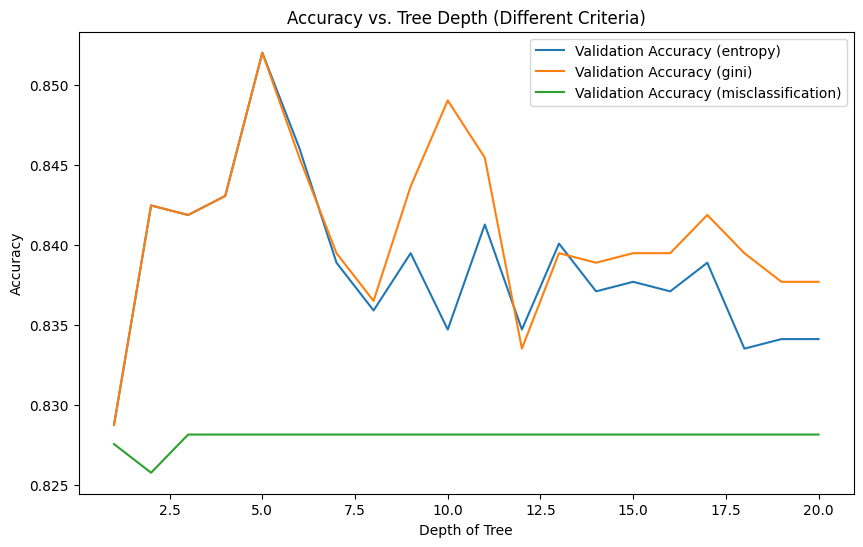

Лучший критерий: entropy с максимальной точностью 0.8520286396181385


In [337]:
criteria = ['entropy', 'gini', 'misclassification']


val_accuracies_criteria = {criterion: [] for criterion in criteria}


for criterion in criteria:
    for depth in range(1, 21):
        model = MyDecisionTreeClassifier(max_depth=depth, criterion=criterion)
        model.fit(X_train.values, y_train.values)
        y_val_pred = model.predict(X_val.values)
        val_accuracies_criteria[criterion].append(accuracy_score(y_val, y_val_pred))


plt.figure(figsize=(10, 6))
for criterion in criteria:
    plt.plot(range(1, 21), val_accuracies_criteria[criterion], label=f'Validation Accuracy ({criterion})')
plt.xlabel('Depth of Tree')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Tree Depth (Different Criteria)')
plt.show()


best_criterion = max(criteria, key=lambda c: max(val_accuracies_criteria[c]))
print(f"Лучший критерий: {best_criterion} с максимальной точностью {max(val_accuracies_criteria[best_criterion])}")


Известным фактом является то, что деревья решений сильно переобучаются при увеличении глубины и просто запоминают трейн.
Замечаете ли вы такой эффект судя по графикам? Что при этом происходит с качеством на валидации?

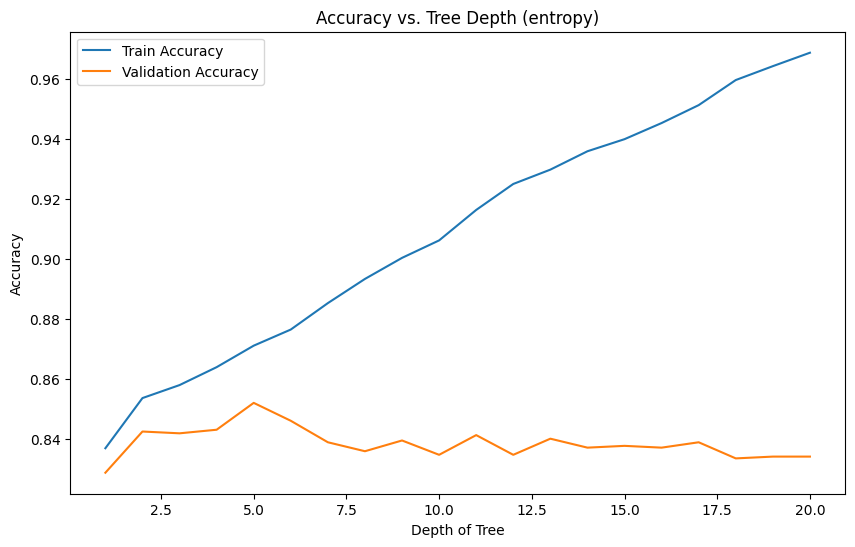

In [340]:
depths = range(1, 21)
train_accuracies_depth = []
val_accuracies_depth = []

for depth in depths:
    model = MyDecisionTreeClassifier(max_depth=depth, criterion=best_criterion)
    model.fit(X_train.values, y_train.values)

    y_train_pred = model.predict(X_train.values)
    y_val_pred = model.predict(X_val.values)

    train_accuracies_depth.append(accuracy_score(y_train, y_train_pred))
    val_accuracies_depth.append(accuracy_score(y_val, y_val_pred))

plt.figure(figsize=(10, 6))
plt.plot(depths, train_accuracies_depth, label='Train Accuracy')
plt.plot(depths, val_accuracies_depth, label='Validation Accuracy')
plt.xlabel('Depth of Tree')
plt.ylabel('Accuracy')
plt.legend()
plt.title(f'Accuracy vs. Tree Depth ({best_criterion})')
plt.show()

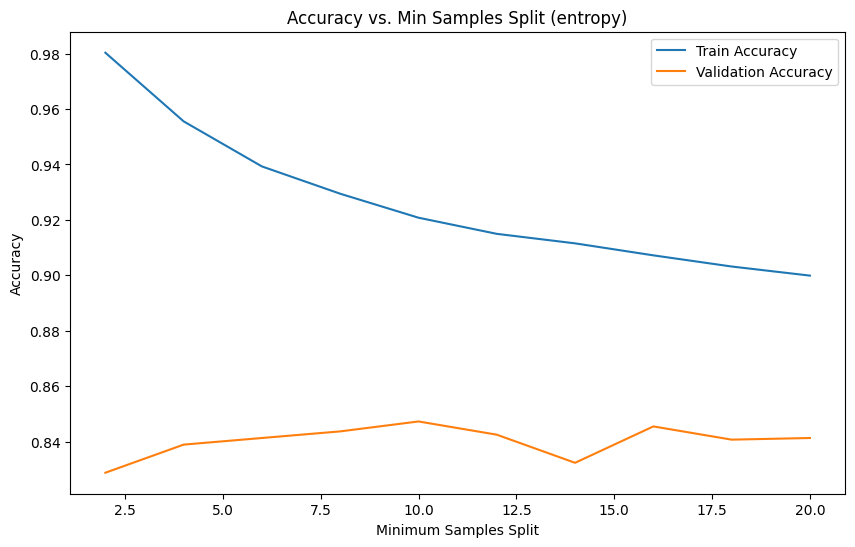

In [341]:
min_samples_splits = range(2, 21, 2)
train_accuracies_split = []
val_accuracies_split = []

for min_split in min_samples_splits:
    model = MyDecisionTreeClassifier(min_samples_split=min_split, criterion=best_criterion)
    model.fit(X_train.values, y_train.values)

    y_train_pred = model.predict(X_train.values)
    y_val_pred = model.predict(X_val.values)

    train_accuracies_split.append(accuracy_score(y_train, y_train_pred))
    val_accuracies_split.append(accuracy_score(y_val, y_val_pred))


plt.figure(figsize=(10, 6))
plt.plot(min_samples_splits, train_accuracies_split, label='Train Accuracy')
plt.plot(min_samples_splits, val_accuracies_split, label='Validation Accuracy')
plt.xlabel('Minimum Samples Split')
plt.ylabel('Accuracy')
plt.legend()
plt.title(f'Accuracy vs. Min Samples Split ({best_criterion})')
plt.show()

## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве.

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший.
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева.

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

In [352]:
model = MyDecisionTreeClassifier(max_depth=5, min_samples_split=10, criterion='entropy')
model.fit(X_train, y_train)


importances = model.get_feature_importance()


feature_names = X.columns
important_features = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)[:10]

print("Топ-10 самых важных признаков:")
for feature, importance in important_features:
    print(f"{feature}: {importance:.4f}")

Топ-10 самых важных признаков:
dec: 0.2549
prob: 0.1734
intel4_1: 0.1391
fun: 0.0876
iid: 0.0821
fun1_1: 0.0409
fun5_2: 0.0399
shar1_1: 0.0395
shar1_s: 0.0384
intel: 0.0331


## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

